In [ ]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SimpleRNN,GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.preprocessing import sequence, text
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import callbacks
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
tqdm.pandas()
import seaborn as sns
from imblearn.over_sampling import SMOTE     
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

In [ ]:
nltk.download('stopwords')
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Copy of spam.csv',delimiter=',',encoding='latin-1')
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()
target_classes=["Ham","Spam"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
def clean_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = df.v2
Y = df.v1
Y = LabelEncoder().fit_transform(Y)

In [ ]:
# cleaning text and stemming
X = X.progress_apply(clean_text)

100%|██████████| 5572/5572 [00:16<00:00, 345.69it/s]


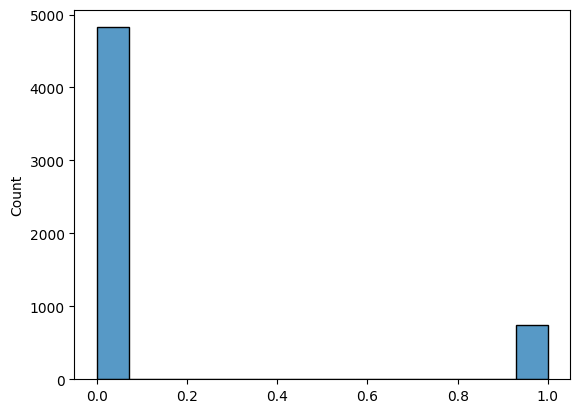

In [ ]:
sns.histplot(data=Y)
plt.show()

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
print('Original dataset shape %s' % Counter(Y))

sm = SMOTE(random_state=42)
X, Y = sm.fit_resample(sequences_matrix, Y)
print('Resampled dataset shape %s' % Counter(Y))

Original dataset shape Counter({0: 4825, 1: 747})
Resampled dataset shape Counter({0: 4825, 1: 4825})


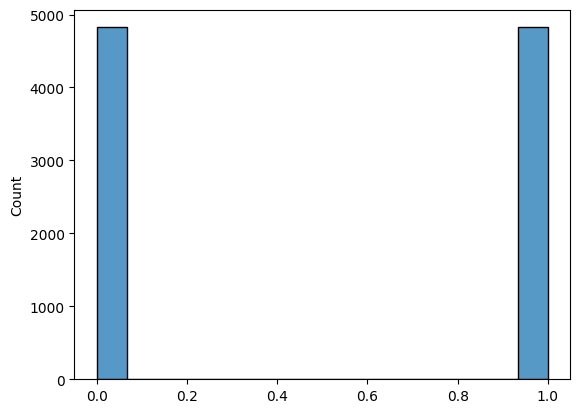

In [ ]:
sns.histplot(data=Y)
plt.show()

In [ ]:
!pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y,stratify=Y, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)
xtest,xval,ytest,yval=train_test_split(xtest,ytest,stratify=ytest,random_state=42,test_size=0.33,shuffle=True)

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def RNN():
    model = Sequential()
    model.add(Embedding(max_words,50,input_length=max_len))
    model.add(LSTM(64,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(256,name='FC1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1,name='out_layer'))
    model.add(Activation('relu'))
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001, rho=0.9),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss', 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    xtrain, 
    ytrain, 
    epochs = 7,
    batch_size = 32,
    validation_data = (xval, yval),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint,early_stopper]
)

Epoch 1/7
212/212 [==============================] - 30s 124ms/step - loss: 1.9508 - accuracy: 0.5090 - val_loss: 1.1854 - val_accuracy: 0.8504 - lr: 1.0000e-04
Epoch 2/7
212/212 [==============================] - 30s 142ms/step - loss: 1.0169 - accuracy: 0.7661 - val_loss: 0.8629 - val_accuracy: 0.8504 - lr: 1.0000e-04
Epoch 3/7
212/212 [==============================] - 25s 119ms/step - loss: 0.8315 - accuracy: 0.8403 - val_loss: 0.7115 - val_accuracy: 0.8734 - lr: 1.0000e-04
Epoch 4/7
212/212 [==============================] - 24s 112ms/step - loss: 0.6726 - accuracy: 0.8616 - val_loss: 0.5998 - val_accuracy: 0.8808 - lr: 1.0000e-04
Epoch 5/7
212/212 [==============================] - 24s 113ms/step - loss: 0.5733 - accuracy: 0.8767 - val_loss: 0.5813 - val_accuracy: 0.9069 - lr: 1.0000e-04
Epoch 6/7
212/212 [==============================] - 26s 120ms/step - loss: 0.5199 - accuracy: 0.8944 - val_loss: 0.5128 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 7/7
212/212 [===============

In [ ]:
accr = model.evaluate(xtest,ytest)

61/61 [==============================] - 2s 38ms/step - loss: 0.5122 - accuracy: 0.8948


In [ ]:
y_preds = (model.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)

61/61 [==============================] - 2s 24ms/step

Classification Report : 
              precision    recall  f1-score   support

         Ham       0.88      0.91      0.90       970
        Spam       0.91      0.88      0.89       969

    accuracy                           0.89      1939
   macro avg       0.90      0.89      0.89      1939
weighted avg       0.90      0.89      0.89      1939



array([[885,  85],
       [119, 850]])

In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

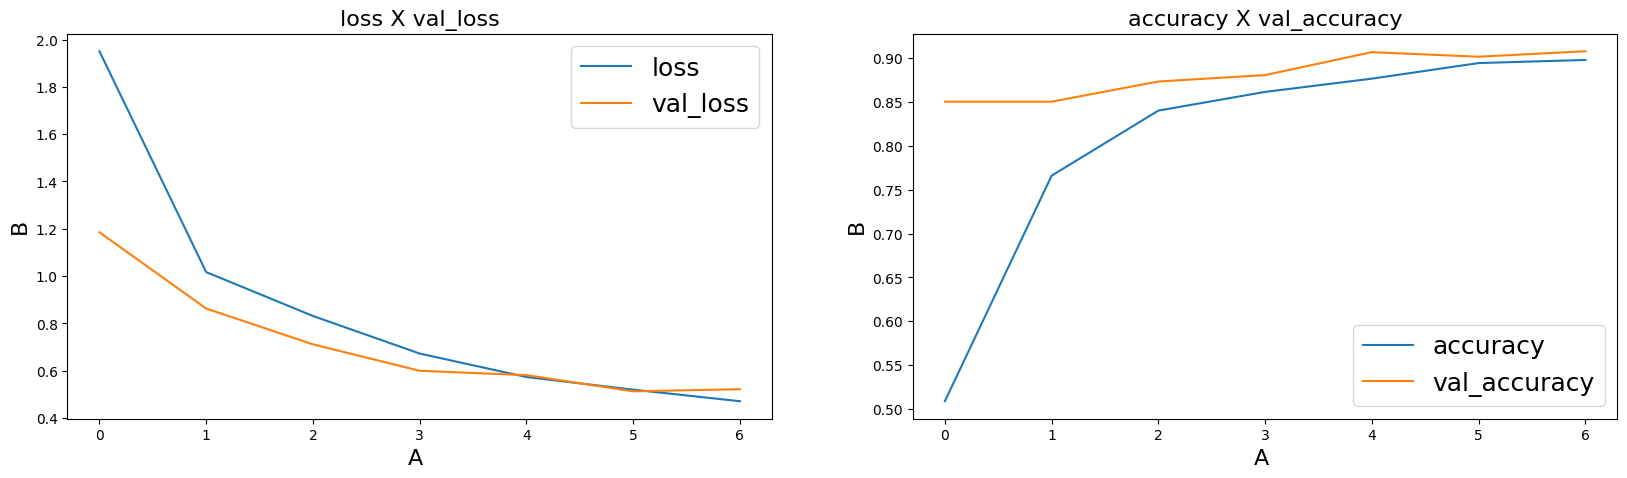

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
scored_model_texttosequence=[]

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_texttosequence.append({'Model': 'LSTM','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

In [ ]:
scored_model_texttosequence

[{'Model': 'LSTM',
  'Precision': 0.8952753849340787,
  'Accuracy': 0.8947911294481692,
  'Recall': 0.8947911294481692,
  'f1': 0.8947578186355576}]

In [ ]:
def GRU_MODEL():
     model = Sequential()
     model.add(Embedding(max_words,50,input_length=max_len))
     model.add(Dropout(0.5))
     model.add(GRU(300))
     model.add(Dense(256,activation='relu'))
     model.add(Dense(1, activation='relu'))
     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
     return model

In [ ]:
model = GRU_MODEL()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001, rho=0.7),metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 dropout_1 (Dropout)         (None, 150, 50)           0         
                                                                 
 gru (GRU)                   (None, 300)               316800    
                                                                 
 dense (Dense)               (None, 256)               77056     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 444,113
Trainable params: 444,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    xtrain, 
    ytrain, 
    epochs = 20,
    batch_size = 32,
    validation_data = (xval, yval),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint,early_stopper]
)

Epoch 1/20
212/212 [==============================] - 140s 642ms/step - loss: 0.8695 - accuracy: 0.7264 - val_loss: 0.5030 - val_accuracy: 0.8368 - lr: 1.0000e-04
Epoch 2/20
212/212 [==============================] - 135s 636ms/step - loss: 0.4333 - accuracy: 0.8463 - val_loss: 0.4276 - val_accuracy: 0.8734 - lr: 1.0000e-04
Epoch 3/20
212/212 [==============================] - 138s 649ms/step - loss: 0.4366 - accuracy: 0.8628 - val_loss: 0.3966 - val_accuracy: 0.8713 - lr: 1.0000e-04
Epoch 4/20
212/212 [==============================] - 135s 639ms/step - loss: 0.4233 - accuracy: 0.8786 - val_loss: 0.4032 - val_accuracy: 0.8881 - lr: 1.0000e-04
Epoch 5/20
212/212 [==============================] - 146s 689ms/step - loss: 0.3978 - accuracy: 0.8789 - val_loss: 0.4344 - val_accuracy: 0.8881 - lr: 1.0000e-04
Epoch 6/20
212/212 [==============================] - 125s 590ms/step - loss: 0.4237 - accuracy: 0.8839 - val_loss: 0.4208 - val_accuracy: 0.8944 - lr: 1.0000e-04


In [ ]:
y_preds = (model.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)

61/61 [==============================] - 10s 156ms/step

Classification Report : 
              precision    recall  f1-score   support

         Ham       0.90      0.82      0.86       970
        Spam       0.84      0.91      0.87       969

    accuracy                           0.87      1939
   macro avg       0.87      0.87      0.87      1939
weighted avg       0.87      0.87      0.87      1939



array([[799, 171],
       [ 90, 879]])

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_texttosequence.append({'Model': 'GRU','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

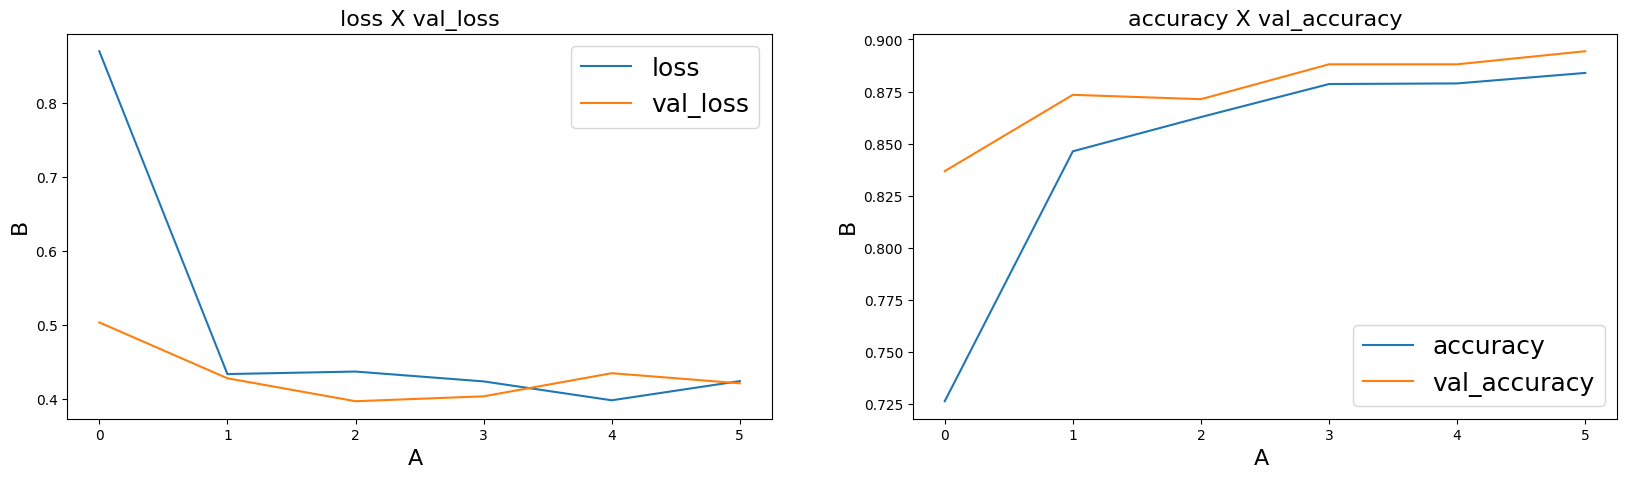

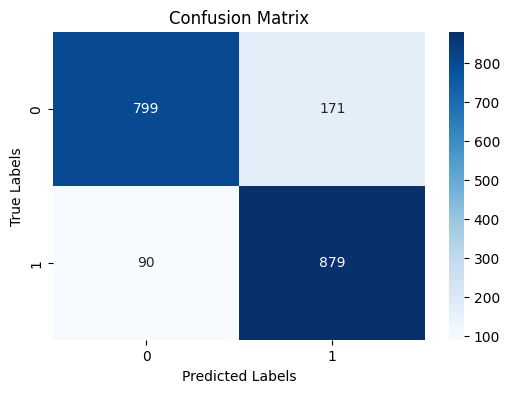

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
cm=metrics.confusion_matrix(ytest, y_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
scored_model_texttosequence

[{'Model': 'GRU',
  'Precision': 0.8446428571428571,
  'Accuracy': 0.838860103626943,
  'Recall': 0.838860103626943,
  'f1': 0.8381813157557744},
 {'Model': 'MultinomialNB',
  'Precision': 0.7737337767187732,
  'Accuracy': 0.7694300518134715,
  'Recall': 0.7694300518134715,
  'f1': 0.7685202030370386},
 {'Model': 'GRU',
  'Precision': 0.8319849476461132,
  'Accuracy': 0.827979274611399,
  'Recall': 0.827979274611399,
  'f1': 0.8274588115672284}]

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(xtrain, ytrain)

MultinomialNB()

In [ ]:
y_preds = (nb.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)


Classification Report : 
              precision    recall  f1-score   support

         Ham       0.74      0.81      0.77       970
        Spam       0.79      0.71      0.75       969

    accuracy                           0.76      1939
   macro avg       0.77      0.76      0.76      1939
weighted avg       0.77      0.76      0.76      1939



array([[788, 182],
       [277, 692]])

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_texttosequence.append({'Model': 'MultinomialNB','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

Vectorizer

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Copy of spam.csv',delimiter=',',encoding='latin-1')
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()
target_classes=["Ham","Spam"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
X = df.v2
Y = df.v1
Y = LabelEncoder().fit_transform(Y)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
count.fit(X)
X = count.transform(X)

In [ ]:
print('Original dataset shape %s' % Counter(Y))

sm = SMOTE(random_state=42)
X, Y = sm.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(Y))

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y,stratify=Y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
classifier = MultinomialNB()

# Define the training sizes to use in the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve scores
train_sizes, train_scores, validation_scores = learning_curve(
    classifier, X, Y, train_sizes=train_sizes, cv=5, scoring='accuracy')

# Compute the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

In [ ]:
ytest.shape

(1930,)

In [ ]:
nb.fit(xtrain, ytrain)
y_preds1 = (nb.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds1, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds1)


Classification Report : 
              precision    recall  f1-score   support

         Ham       0.84      0.99      0.91       965
        Spam       0.99      0.82      0.89       965

    accuracy                           0.90      1930
   macro avg       0.91      0.90      0.90      1930
weighted avg       0.91      0.90      0.90      1930



array([[953,  12],
       [175, 790]])

In [ ]:
scored_model_countvectorizer=[]

In [ ]:
accr = accuracy_score(ytest,y_preds1)
prec = precision_score(ytest, y_preds1, average='weighted')
rec = recall_score(ytest, y_preds1, average='weighted')
f1 = f1_score(ytest, y_preds1, average='weighted')
scored_model_countvectorizer.append({'Model': 'MultinomialNB','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

LSTM-VECTOR

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y,stratify=Y, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)
xtest,xval,ytest,yval=train_test_split(xtest,ytest,stratify=ytest,random_state=42,test_size=0.33,shuffle=True)

In [ ]:
vector_X = xtrain_nu[:,:,None]
vector_XT= xtest_num_array[:,:,None]

In [ ]:
vector_X.shape

In [ ]:
xtrain_num_array.shape

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
lab = LabelBinarizer()
lab.fit(ytest)
y_tf = lab.transform(ytest)

In [ ]:
def RNN2():
    model = Sequential()
    model.add(Embedding(max_words,50,input_length=None))
    model.add(LSTM(64))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.9))
    model.add(Dense(1,name='out_layer'))
    model.add(Activation('relu'))
    return model

In [ ]:
model3 = RNN2()
model3.summary()
model3.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001, rho=0.9),metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 50)          50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_3 (Activation)   (None, 1)               

In [ ]:
history_LSTM = model3.fit(
    xtrain, ytrain,
    epochs = 7,
    batch_size = 32,
    validation_data = (xval, yval),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
 23/242 [=>............................] - ETA: 1:01 - loss: 3.4477 - accuracy: 0.5041

In [ ]:
y_preds = (model3.predict(xtest)>0.5).astype(int)
y_preds_flat=y_preds.flatten()
print("\nClassification Report : ")
print(classification_report(ytest, y_preds_flat, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_countvectorizer.append({'Model': 'LSTM','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

In [ ]:
def GRU_MODEL2():
     model = Sequential()
     model.add(Embedding(max_words,50,input_length=None))
     model.add(Dropout(0.5))
     model.add(GRU(300))
     model.add(Dense(256,name='FC1',activation='relu'))
     model.add(Dense(1, activation='sigmoid'))
     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
     return model

In [ ]:
model4 = GRU_MODEL2()
model4.summary()
model4.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001, rho=0.9),metrics=['accuracy'])

In [ ]:
history_GRU = model4.fit(
    xtrain, ytrain,
    epochs = 7,
    batch_size = 32,
    validation_data = (xval, yval),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

In [ ]:
ytest

In [ ]:
y_preds = (model4.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_countvectorizer.append({'Model': 'GRU','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

GLOVE EMBEDDING

In [ ]:
token = text.Tokenizer(num_words=None)
token.fit_on_texts(X)
vocab=len(token.word_index)+1
word_index = token.word_index

In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

2196018it [03:37, 10113.44it/s]


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word  , i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 6235/6235 [00:00<00:00, 236324.98it/s]


In [ ]:
embedding_matrix

In [ ]:
embedding_matrix.shape

In [ ]:
Y.shape

In [ ]:
def GRU_MODEL_GLOVE():
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(GRU(300))
     model.add(Dense(256,name='FC1'))
     model.add(Activation('relu'))
     model.add(Dropout(0.7))
     model.add(Dense(1,name='out_layer'))
     model.add(Activation('sigmoid')) 
     return model

In [ ]:
model5 = GRU_MODEL_GLOVE()
model5.summary()
model5.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001, rho=0.9),metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          1870800   
                                                                 
 gru_2 (GRU)                 (None, 300)               541800    
                                                                 
 FC1 (Dense)                 (None, 256)               77056     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_5 (Activation)   (None, 1)                

In [ ]:
history_GL_GRU = model5.fit(
    xtrain, ytrain,
    epochs = 20,
    batch_size = 32,
    validation_data = (xval, yval),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint,early_stopper]
)

Epoch 1/20
242/242 [==============================] - 6s 17ms/step - loss: 0.4954 - accuracy: 0.7618 - val_loss: 0.3569 - val_accuracy: 0.8565 - lr: 1.0000e-04
Epoch 2/20
242/242 [==============================] - 3s 14ms/step - loss: 0.3158 - accuracy: 0.8749 - val_loss: 0.3163 - val_accuracy: 0.8819 - lr: 1.0000e-04
Epoch 3/20
242/242 [==============================] - 3s 13ms/step - loss: 0.2766 - accuracy: 0.8911 - val_loss: 0.2809 - val_accuracy: 0.8943 - lr: 1.0000e-04
Epoch 4/20
242/242 [==============================] - 3s 13ms/step - loss: 0.2516 - accuracy: 0.9014 - val_loss: 0.2646 - val_accuracy: 0.8953 - lr: 1.0000e-04
Epoch 5/20
242/242 [==============================] - 3s 14ms/step - loss: 0.2305 - accuracy: 0.9136 - val_loss: 0.2489 - val_accuracy: 0.9109 - lr: 1.0000e-04
Epoch 6/20
242/242 [==============================] - 3s 14ms/step - loss: 0.2147 - accuracy: 0.9183 - val_loss: 0.3010 - val_accuracy: 0.8824 - lr: 1.0000e-04
Epoch 7/20
242/242 [====================

In [ ]:
y_preds = (model5.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)

61/61 [==============================] - 0s 7ms/step

Classification Report : 
              precision    recall  f1-score   support

         Ham       0.92      0.92      0.92       965
        Spam       0.92      0.92      0.92       965

    accuracy                           0.92      1930
   macro avg       0.92      0.92      0.92      1930
weighted avg       0.92      0.92      0.92      1930



array([[884,  81],
       [ 75, 890]])

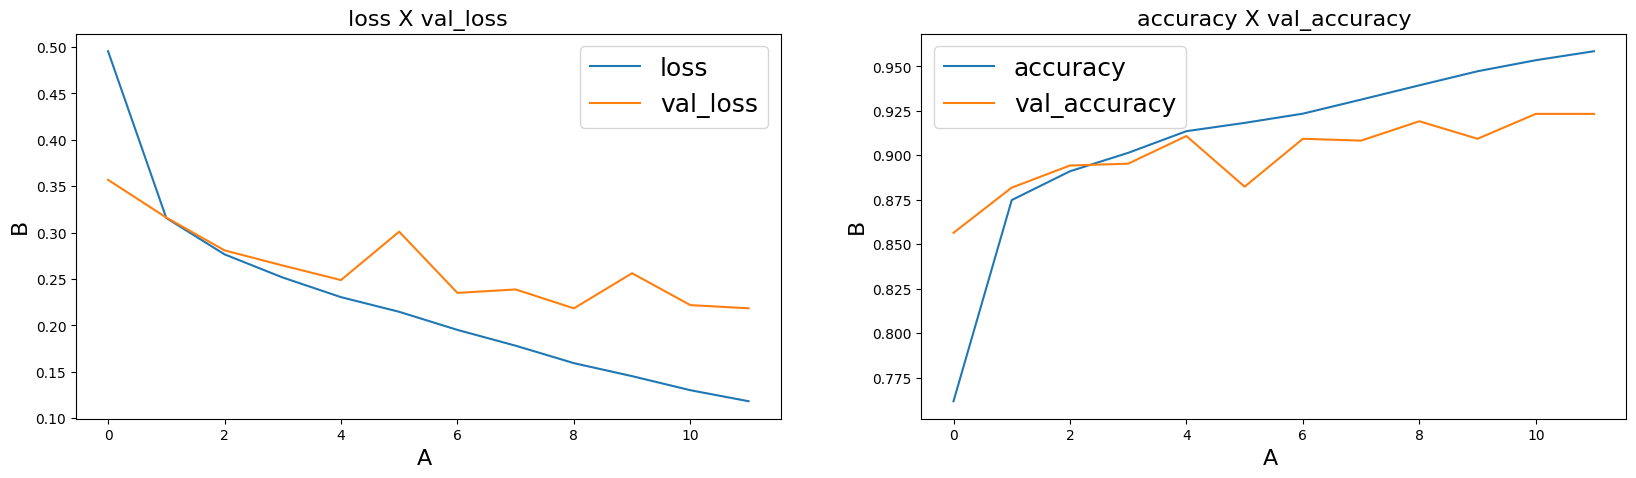

In [ ]:
plot_learning_curves(history_GL_GRU, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
scored_model_glove=[]

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_glove.append({'Model': 'GRU','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

In [ ]:
def LSTM_MODEL_GLOVE():
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(LSTM(64))
     model.add(Dense(256,name='FC1'))
     model.add(Activation('relu'))
     model.add(Dropout(0.7))
     model.add(Dense(1,name='out_layer'))
     model.add(Activation('sigmoid')) 
     return model

In [ ]:
model6 = LSTM_MODEL_GLOVE()
model6.summary()
model6.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001, rho=0.9),metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 300)          1870800   
                                                                 
 lstm_4 (LSTM)               (None, 64)                93440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_14 (Activation)  (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_15 (Activation)  (None, 1)                

In [ ]:
xtrain.shape

(7720, 150)

In [ ]:
history_GL_LSTM = model6.fit(
    xtrain, ytrain,
    epochs = 10,
    batch_size = 32,
    validation_data = (xval, yval),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint,early_stopper]
)

Epoch 1/10
242/242 [==============================] - 5s 14ms/step - loss: 0.5890 - accuracy: 0.7124 - val_loss: 0.4443 - val_accuracy: 0.8435 - lr: 1.0000e-04
Epoch 2/10
242/242 [==============================] - 2s 10ms/step - loss: 0.3747 - accuracy: 0.8610 - val_loss: 0.3554 - val_accuracy: 0.8663 - lr: 1.0000e-04
Epoch 3/10
242/242 [==============================] - 2s 10ms/step - loss: 0.3263 - accuracy: 0.8734 - val_loss: 0.3255 - val_accuracy: 0.8777 - lr: 1.0000e-04
Epoch 4/10
242/242 [==============================] - 2s 9ms/step - loss: 0.3007 - accuracy: 0.8799 - val_loss: 0.3066 - val_accuracy: 0.8850 - lr: 1.0000e-04
Epoch 5/10
242/242 [==============================] - 2s 9ms/step - loss: 0.2750 - accuracy: 0.8918 - val_loss: 0.2829 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 6/10
242/242 [==============================] - 3s 11ms/step - loss: 0.2550 - accuracy: 0.9016 - val_loss: 0.2679 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 7/10
242/242 [======================

In [ ]:
y_preds = (model6.predict(xtest)>0.5)
print("\nClassification Report : ")
print(classification_report(ytest, y_preds, target_names=target_classes))
metrics.confusion_matrix(ytest, y_preds)

61/61 [==============================] - 1s 5ms/step

Classification Report : 
              precision    recall  f1-score   support

         Ham       0.91      0.93      0.92       965
        Spam       0.93      0.91      0.92       965

    accuracy                           0.92      1930
   macro avg       0.92      0.92      0.92      1930
weighted avg       0.92      0.92      0.92      1930



array([[901,  64],
       [ 91, 874]])

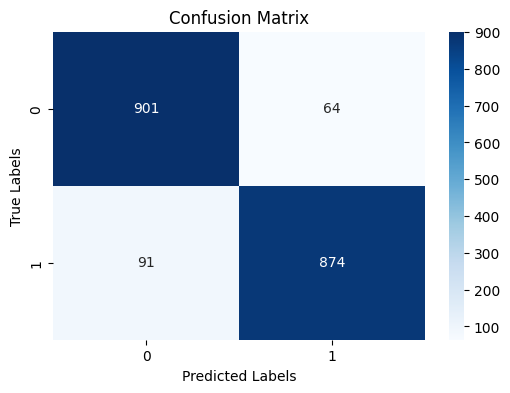

In [ ]:
cm=metrics.confusion_matrix(ytest, y_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

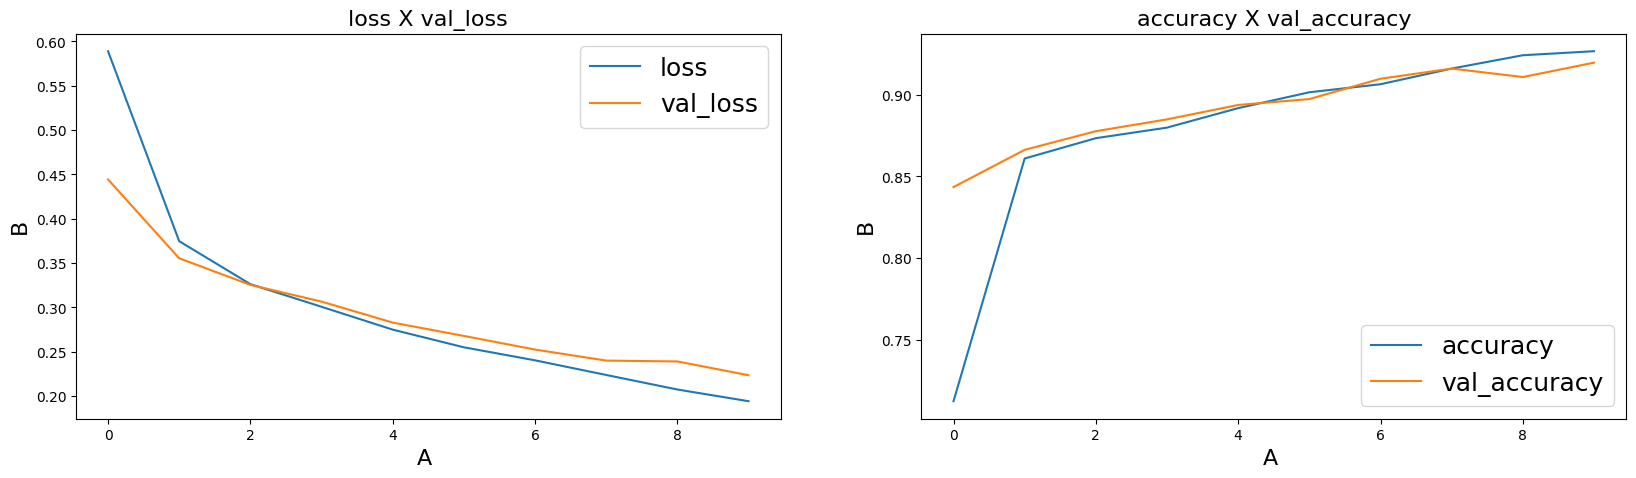

In [ ]:
plot_learning_curves(history_GL_LSTM, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_glove.append({'Model': 'LSTM','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

In [ ]:
pd.DataFrame(scored_model_texttosequence)

In [ ]:
pd.DataFrame(scored_model_countvectorizer)

In [ ]:
pd.DataFrame(scored_model_glove)

,Model,Precision,Accuracy,Recall,f1
0,GRU,0.919187,0.919171,0.919171,0.919170
1,LSTM,0.920018,0.919689,0.919689,0.919673


In [ ]:
from sklearn.naive_bayes import GaussianNB

mod = "Gaussian Naive Bayes"
clssF = GaussianNB() 
clssF.fit(x_train, y_train) 
Eval(y_test, clssF.predict(x_test), "Count" , mod)

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
import gensim
import os
import shutil
import hashlib
from sys import platform

def getFileLineNums(filename):
    f = open(filename, 'r')
    count = 0
    for line in f:
        count += 1
    return count


def prepend_line(infile, outfile, line):
    with open(infile, 'r') as old:
        with open(outfile, 'w') as new:
            new.write(str(line) + "\n")
            shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
    with open(infile, 'r') as fin:
        with open(outfile, 'w') as fout:
            fout.write(line + "\n")
            for line in fin:
                fout.write(line)

def load(filename):
    num_lines = getFileLineNums(filename)
    gensim_file = 'glove_model.txt'
    gensim_first_line = "{} {}".format(num_lines, 300)
    # Prepends the line.
    if platform == "linux" or platform == "linux2":
        prepend_line(filename, gensim_file, gensim_first_line)
    else:
        prepend_slow(filename, gensim_file, gensim_first_line)

    model = gensim.models.KeyedVectors.load_word2vec_format(gensim_file)
    return model
model = load('/content/drive/MyDrive/kaggle/glove.840B.300d.txt')

In [ ]:
# Load pre-trained GloVe embeddings
# glove_model = KeyedVectors.load_word2vec_format('//content/drive/MyDrive/kaggle/glove.840B.300d.txt', binary=False)

# Define a function to calculate the mean GloVe embedding for a document
def get_mean_embedding(document):
    tokens = document.split()
    embeddings = [model[token] for token in tokens if token in model.key_to_index]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
from sklearn.naive_bayes import GaussianNB
embeddings = df['v2'].apply(get_mean_embedding).to_list()

X = np.array(embeddings)

# Convert the labels to a numpy array
y = np.array(df['v1'])

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train a Gaussian Naive Bayes classifier on the training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

In [ ]:
accuracy = gnb.score(X_test, y_test)
print(f"Accuracy: {accuracy}")


In [ ]:
accuracy = gnb.(X_test, y_test)
print(f"Accuracy: {accuracy}")

In [ ]:
X_test

In [ ]:
y_preds = (gnb.predict(X_test)>0.5)

In [ ]:
accr = accuracy_score(ytest,y_preds)
prec = precision_score(ytest, y_preds, average='weighted')
rec = recall_score(ytest, y_preds, average='weighted')
f1 = f1_score(ytest, y_preds, average='weighted')
scored_model_glove.append({'Model': 'LSTM','Precision': prec,'Accuracy':accr,'Recall':rec,'f1':f1})

In [ ]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert the GloVe embeddings to the word2vec format
glove_input_file = '/content/drive/MyDrive/kaggle/glove.840B.300d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted GloVe embeddings
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Define a function to calculate the mean GloVe embedding for a document
def get_mean_embedding(document):
    tokens = document.split()
    embeddings = [glove_model[token] for token in tokens if token in glove_model.vocab]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(glove_model.vector_size)




In [ ]:
# Calculate the mean GloVe embedding for each document
embeddings = df['v2'].apply(get_mean_embedding).to_list()

# Convert the embeddings to a numpy array
X = np.array(embeddings)

# Convert the labels to a numpy array
y = np.array(df['v1'])

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train a Gaussian Naive Bayes classifier on the training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = gnb.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

accuracy = gnb.score(X_test, y_test)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")